In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = "/content/drive/My Drive/Colab Notebooks/garbage"

data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
2281


In [3]:
import os
absolute_path = os.path.abspath('.')
print("Full path: " + absolute_path)
print("Directory Path: " + os.path.dirname(absolute_path))

img = PIL.Image.open(str(next(data_dir.glob('metal/*'))))

img_height, img_width = img.size
batch_size = 32
val_split = 0.3


Full path: /content
Directory Path: /


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="training",
  seed=5336,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=val_split,
  subset="validation",
  seed=5336,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2281 files belonging to 6 classes.
Using 1597 files for training.
Found 2281 files belonging to 6 classes.
Using 684 files for validation.


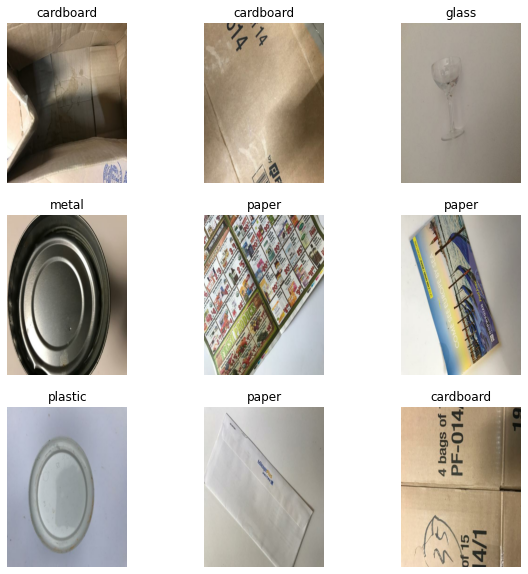

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")


In [6]:
# Autotune
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# Normalization des pixels des images
normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [8]:
# Creating model

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  #layers.Conv2D(32, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  #layers.Conv2D(64, 3, padding='same', activation='relu'),
  #layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [9]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 512, 384, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 512, 384, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 192, 16)     0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 786432)            0         
                                                                 
 dense (Dense)               (None, 128)               100663424 
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                        

In [11]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
50/50 [==============================] - 456s 5s/step - loss: 33.6685 - accuracy: 0.2066 - val_loss: 1.8788 - val_accuracy: 0.2442
Epoch 2/10
50/50 [==============================] - 6s 111ms/step - loss: 1.5286 - accuracy: 0.3770 - val_loss: 1.4850 - val_accuracy: 0.4196
Epoch 3/10
50/50 [==============================] - 6s 111ms/step - loss: 1.3076 - accuracy: 0.5066 - val_loss: 1.4524 - val_accuracy: 0.3977
Epoch 4/10
50/50 [==============================] - 5s 110ms/step - loss: 1.1155 - accuracy: 0.6180 - val_loss: 1.4359 - val_accuracy: 0.4854
Epoch 5/10
50/50 [==============================] - 5s 110ms/step - loss: 0.8963 - accuracy: 0.7070 - val_loss: 1.4197 - val_accuracy: 0.4635
Epoch 6/10
50/50 [==============================] - 6s 110ms/step - loss: 0.7465 - accuracy: 0.7552 - val_loss: 1.4395 - val_accuracy: 0.5044
Epoch 7/10
50/50 [==============================] - 6s 110ms/step - loss: 0.5919 - accuracy: 0.8334 - val_loss: 1.4853 - val_accuracy: 0.5249
Epoch 

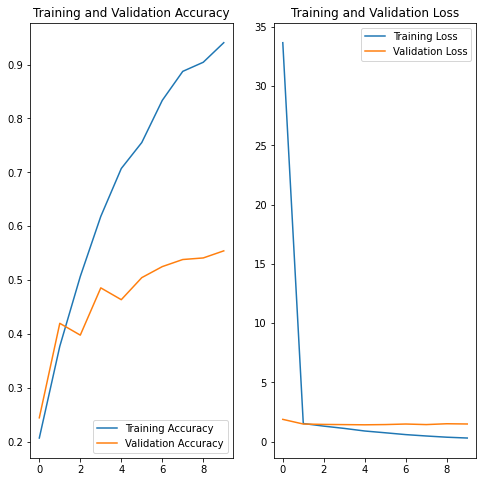

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
